In [1]:
%load_ext pretty_jupyter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [5]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [8]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [9]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [10]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [11]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [12]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Read previous, non-tracked labels
We ran a preliminary analysis of our dataset that wasn't tracked for reproducibility. Here, we'll retrieve the labels for visualization and comparison to check for consistency.

In [13]:
original_uuid = '3868592c-0087-4ed8-98b2-4bf1b8676111'
original_df = read_parquet_uuid(original_uuid)
original_df = original_df[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
original_df = original_df.rename({'AIFI_L1': 'original_L1', 'AIFI_L2': 'original_L2', 'AIFI_L3': 'original_L3'}, axis = 1)

In [14]:
original_df.head()

,barcodes,original_L1,original_L2,original_L3
0,05ea9806794211eb93b836d1cb6129eb,DC,cDC1,cDC1
1,e225c914794011eb9282e2ceeb91ba52,DC,cDC1,cDC1
2,b1379eae795411eb958b0245821e6993,DC,cDC1,cDC1
3,b13d3a8a795411eb958b0245821e6993,DC,cDC1,cDC1
4,b1430d16795411eb958b0245821e6993,DC,cDC1,cDC1


## Markers for dotplots

In [15]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'IL7R', # T cells
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [16]:
class_markers = [
    'CD44'
]

## Read cell type hierarchy

In [17]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [18]:
search_id = 'thorium-zirconium-nobelium'

Retrieve files stored in our HISE project store

In [19]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [20]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [21]:
search_df['AIFI_L3'].tolist()

['BaEoMaP cell',
 'CLP cell',
 'CMP cell',
 'Erythrocyte',
 'Platelet',
 'thorium-zirconium-nobelium/diha filtered celltypist other types reasons']

## Review BaEoMaP cell

In [22]:
cell_type = 'BaEoMaP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [23]:
type_uuid

'5d42b57e-9021-4b47-9e9e-c6df30083e9f'

In [24]:
adata = read_adata_uuid(type_uuid)

### Clustering

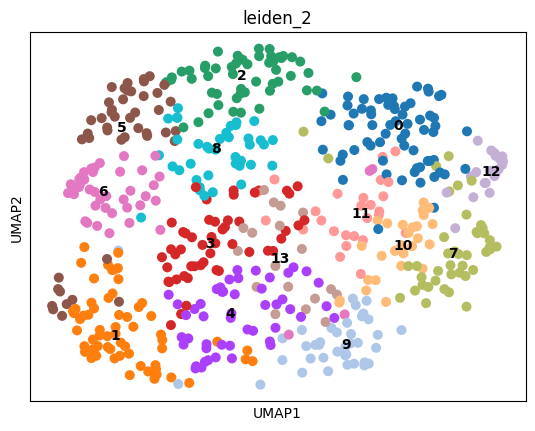

In [25]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

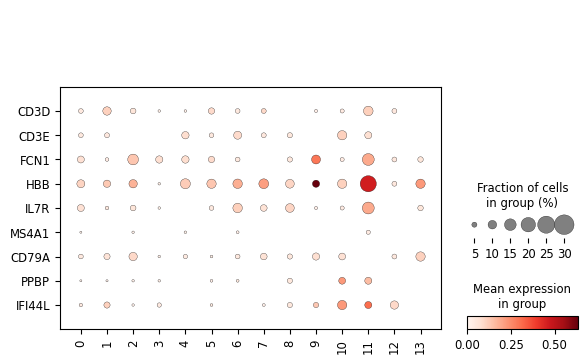

In [26]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [27]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     66
1     62
2     52
3     50
4     49
5     45
6     44
7     42
8     39
9     38
10    27
11    26
12    21
13    18
Name: count, dtype: int64

### Comparison to original labels

In [28]:
adata = add_labels(adata, original_df)

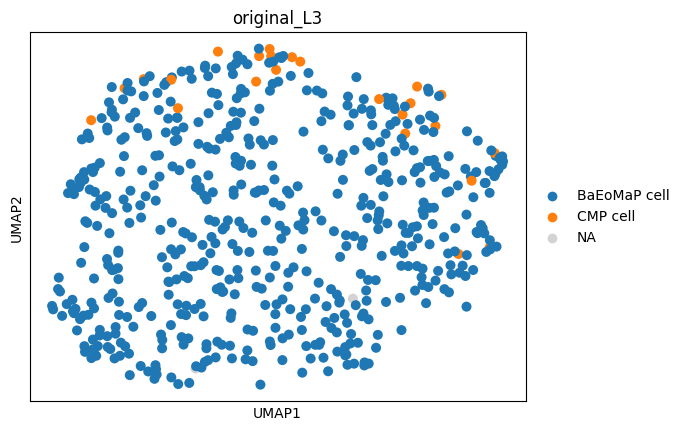

In [29]:
sc.pl.umap(adata, color = 'original_L3')

In [30]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
BaEoMaP cell    553
CMP cell         24
NaN               2
Name: count, dtype: int64

In [31]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
BaEoMaP cell    0.955095
CMP cell        0.041451
NaN             0.003454
Name: count, dtype: float64

## Review CLP cell

In [32]:
cell_type = 'CLP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [33]:
type_uuid

'b80001d4-bdae-49b7-8315-24acd335217f'

In [34]:
adata = read_adata_uuid(type_uuid)

downloading fileID: b80001d4-bdae-49b7-8315-24acd335217f
Files have been successfully downloaded!


### Clustering

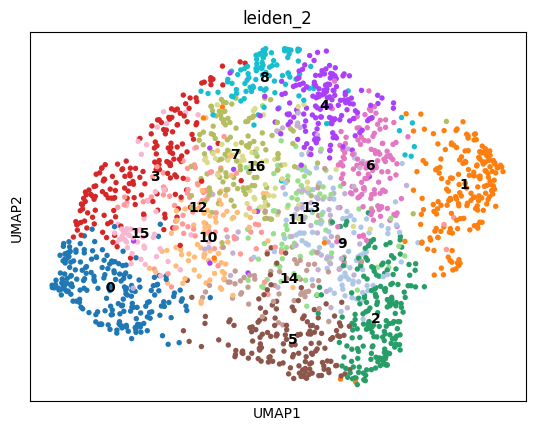

In [35]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

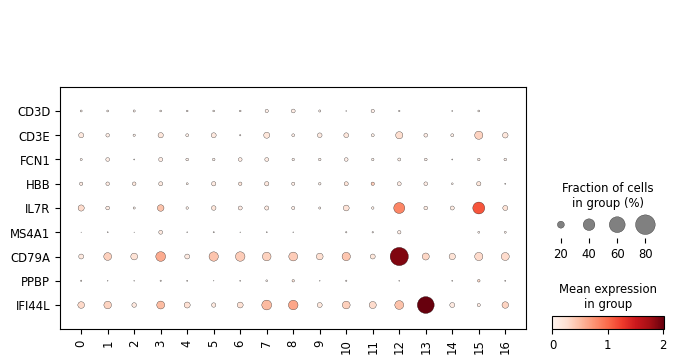

In [36]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### Cluster counts

In [37]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     211
1     192
2     190
3     172
4     158
5     148
6     125
7     120
8      98
9      94
10     82
11     78
12     76
13     69
14     62
15     56
16     54
Name: count, dtype: int64

### Comparison to original labels

In [38]:
adata = add_labels(adata, original_df)

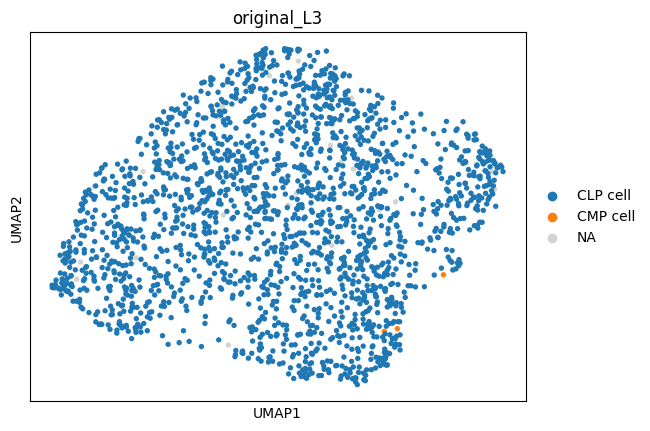

In [39]:
sc.pl.umap(adata, color = 'original_L3')

In [40]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CLP cell    1954
NaN           28
CMP cell       3
Name: count, dtype: int64

In [41]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CLP cell    0.984383
NaN         0.014106
CMP cell    0.001511
Name: count, dtype: float64

## Review CMP cell

In [42]:
cell_type = 'CMP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [43]:
type_uuid

'8a71c65a-09ef-4c1a-b294-4a3fb591ea6d'

In [44]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 8a71c65a-09ef-4c1a-b294-4a3fb591ea6d
Files have been successfully downloaded!


### Clustering

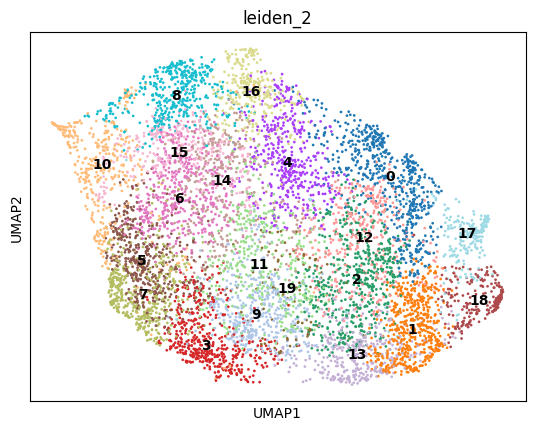

In [45]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

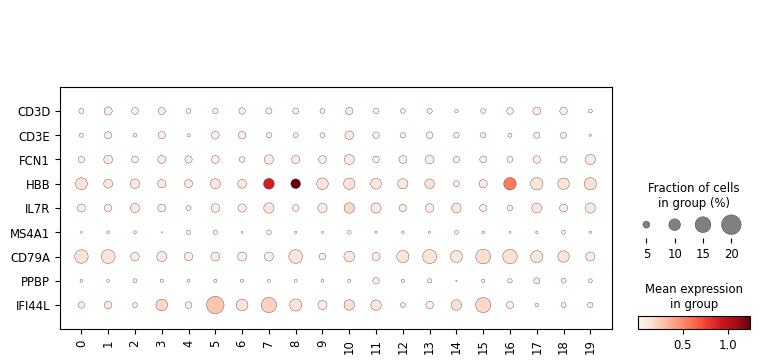

In [46]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### Cluster counts

In [47]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     605
1     541
2     518
3     473
4     458
5     451
6     450
7     450
8     439
9     437
10    406
11    391
12    379
13    377
14    350
15    306
16    295
17    240
18    217
19     84
Name: count, dtype: int64

### Comparison to original labels

In [48]:
adata = add_labels(adata, original_df)

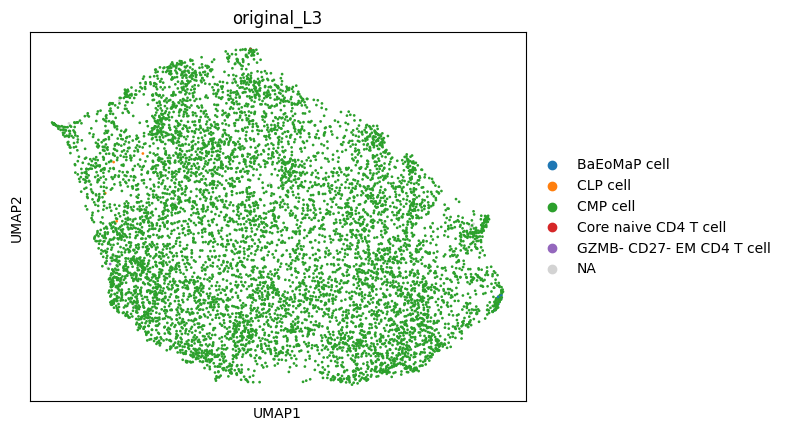

In [49]:
sc.pl.umap(adata, color = 'original_L3')

In [50]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CMP cell                     7839
NaN                            17
BaEoMaP cell                    5
CLP cell                        4
Core naive CD4 T cell           1
GZMB- CD27- EM CD4 T cell       1
Name: count, dtype: int64

In [51]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CMP cell                     0.996441
NaN                          0.002161
BaEoMaP cell                 0.000636
CLP cell                     0.000508
Core naive CD4 T cell        0.000127
GZMB- CD27- EM CD4 T cell    0.000127
Name: count, dtype: float64

## Review Erythrocyte

In [52]:
cell_type = 'Erythrocyte'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [53]:
type_uuid

'e459301b-39a5-4ea6-a579-0f2839edd11e'

In [54]:
adata = read_adata_uuid(type_uuid)

downloading fileID: e459301b-39a5-4ea6-a579-0f2839edd11e
Files have been successfully downloaded!


### Clustering

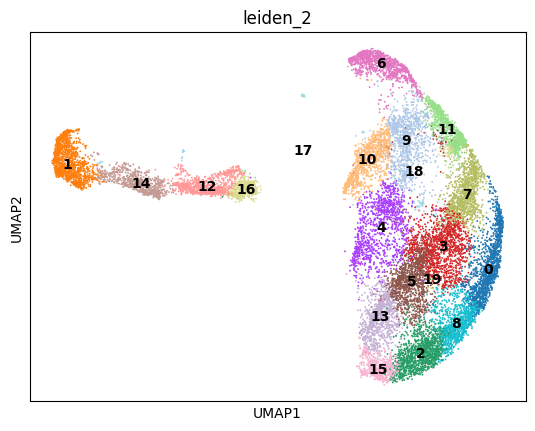

In [55]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

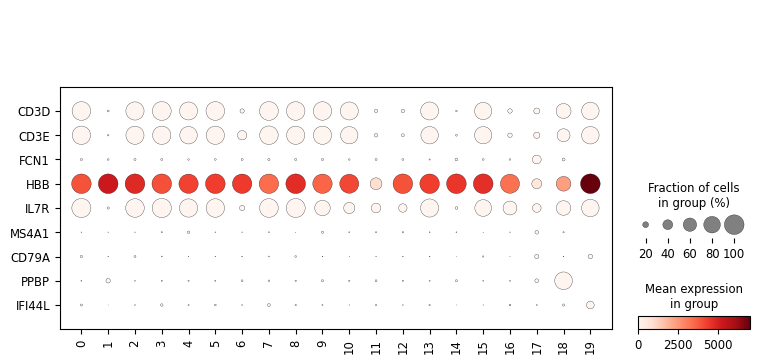

In [56]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### Cluster counts

In [57]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1424
1     1315
2     1265
3     1241
4     1111
5     1074
6     1057
7     1031
8     1028
9      970
10     966
11     923
12     915
13     911
14     821
15     653
16     523
17     143
18      75
19       7
Name: count, dtype: int64

### Comparison to original labels

In [58]:
adata = add_labels(adata, original_df)

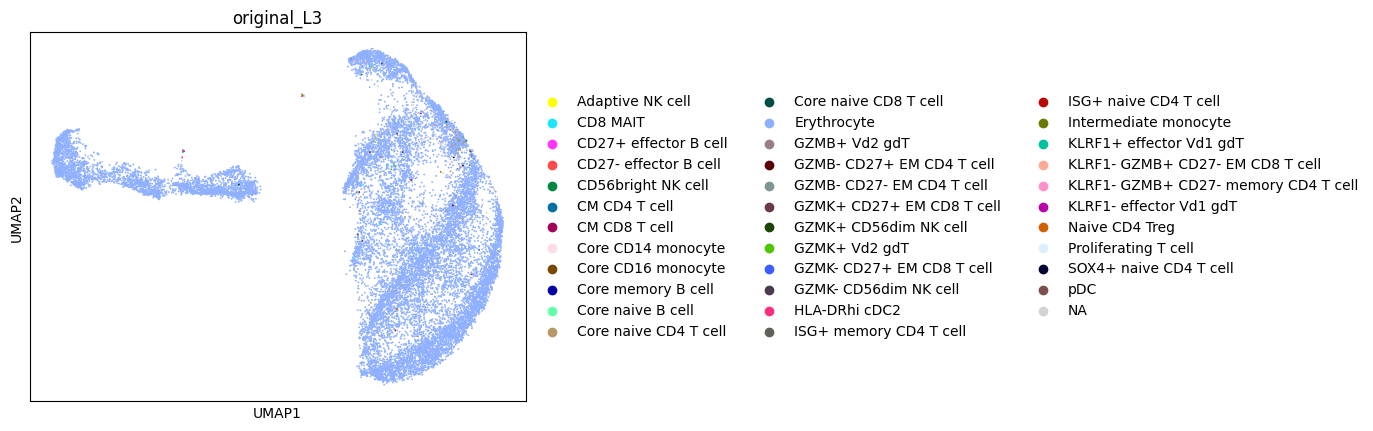

In [59]:
sc.pl.umap(adata, color = 'original_L3')

In [60]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Erythrocyte                             16797
NaN                                       499
Core naive CD4 T cell                      60
GZMB- CD27- EM CD4 T cell                  14
Core naive B cell                           9
CD8 MAIT                                    9
Core CD14 monocyte                          9
GZMB- CD27+ EM CD4 T cell                   5
KLRF1- GZMB+ CD27- EM CD8 T cell            4
GZMK+ CD27+ EM CD8 T cell                   4
CM CD4 T cell                               4
Core CD16 monocyte                          4
Adaptive NK cell                            3
GZMB+ Vd2 gdT                               3
GZMK- CD56dim NK cell                       3
GZMK+ Vd2 gdT                               2
Naive CD4 Treg                              2
KLRF1- effector Vd1 gdT                     2
ISG+ naive CD4 T cell                       2
Core memory B cell                          2
CD27- effector B cell                       2
GZMK- CD27+ EM CD8 T c

In [61]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Erythrocyte                             0.962413
NaN                                     0.028591
Core naive CD4 T cell                   0.003438
GZMB- CD27- EM CD4 T cell               0.000802
Core naive B cell                       0.000516
CD8 MAIT                                0.000516
Core CD14 monocyte                      0.000516
GZMB- CD27+ EM CD4 T cell               0.000286
KLRF1- GZMB+ CD27- EM CD8 T cell        0.000229
GZMK+ CD27+ EM CD8 T cell               0.000229
CM CD4 T cell                           0.000229
Core CD16 monocyte                      0.000229
Adaptive NK cell                        0.000172
GZMB+ Vd2 gdT                           0.000172
GZMK- CD56dim NK cell                   0.000172
GZMK+ Vd2 gdT                           0.000115
Naive CD4 Treg                          0.000115
KLRF1- effector Vd1 gdT                 0.000115
ISG+ naive CD4 T cell                   0.000115
Core memory B cell                      0.000115
CD27- ef

## Review Platelet

In [62]:
cell_type = 'Platelet'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [63]:
type_uuid

'2498790d-2beb-4a1a-84ae-9f683f92364a'

In [64]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 2498790d-2beb-4a1a-84ae-9f683f92364a
Files have been successfully downloaded!


### Clustering

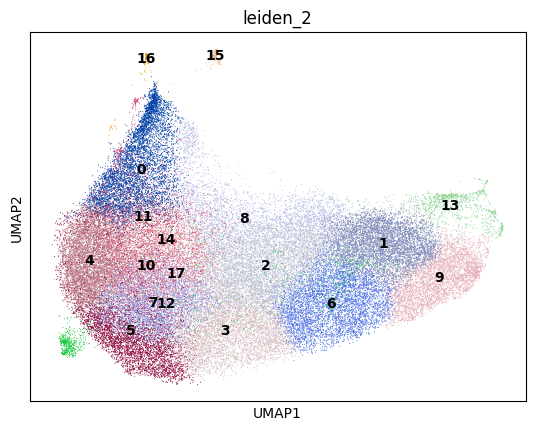

In [65]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

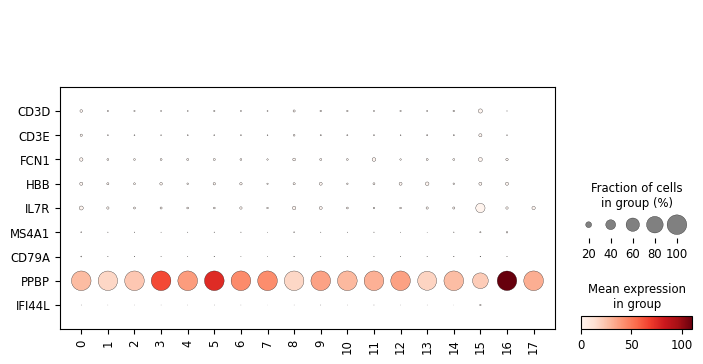

In [66]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### Cluster counts

In [67]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     5427
1     5245
2     5235
3     5173
4     5019
5     5018
6     5011
7     3909
8     3857
9     3832
10    3719
11    1966
12    1158
13    1152
14    1054
15     229
16     118
17      21
Name: count, dtype: int64

### Comparison to original labels

In [68]:
adata = add_labels(adata, original_df)

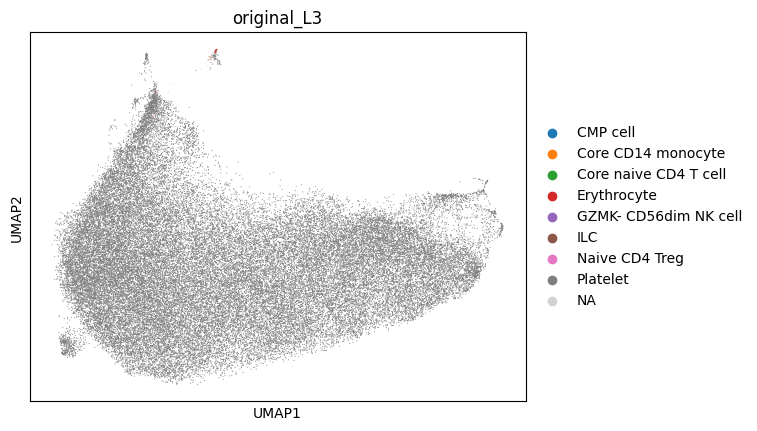

In [69]:
sc.pl.umap(adata, color = 'original_L3')

In [70]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Platelet                 56902
NaN                        214
Erythrocyte                 20
GZMK- CD56dim NK cell        2
CMP cell                     1
Core CD14 monocyte           1
Core naive CD4 T cell        1
ILC                          1
Naive CD4 Treg               1
Name: count, dtype: int64

In [71]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Platelet                 0.995783
NaN                      0.003745
Erythrocyte              0.000350
GZMK- CD56dim NK cell    0.000035
CMP cell                 0.000017
Core CD14 monocyte       0.000017
Core naive CD4 T cell    0.000017
ILC                      0.000017
Naive CD4 Treg           0.000017
Name: count, dtype: float64

In [72]:
os.system('jupyter nbconvert --to html --template pj 13g-Python_review_filtered_L3_other_data.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 13g-Python_review_filtered_L3_other_data.ipynb to html
[NbConvertApp] Writing 7131074 bytes to 13g-Python_review_filtered_L3_other_data.html


0

In [73]:
import session_info
session_info.show()